# Feature extraction

So, this is the first Notebook of this *Course No4 project* :-)

This first Notebook will extract a higk-level feature ot the *"Swissroads" data set from EPFL Extension School*

I've made the choice to use *Inception v3* which will result in a 2048 high.level features.

Let's start...

## What kind of images are we talking about ?

First of all, I should grab some information on the images: width, height, number of color. Those element are very important as they will be used to build our high-level feature.

To do so, I'll use the *PIL.Image* lib and open one of the picture of the train set

> Note: I assume that all the images have the same characteristics

Image size: (256, 256) - Color: RGB



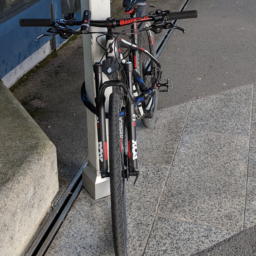

In [9]:
from PIL import Image
import os

img=Image.open(os.path.join('data','train', 'bike', 'bike-0001.png'))

print("Image size: {} - Color: {}\n".format(img.size, img.mode))
img

First thing to notice, the images will have to be resized as the *Inception V3* neural network expects image size = 299x299.

I'll use the *resize()* method of the PIL.Image lib to upscale the image dataset (resize algorythm will be *Image.BICUBIC*)

Here is how the upscaled image looks like:

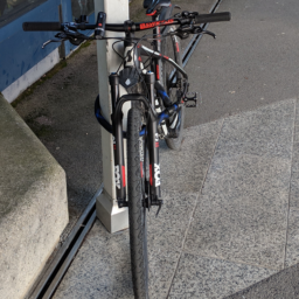

In [10]:
img_resized=img.resize([299,299], Image.BICUBIC)
img_resized

### Conclusion

1. Images will have to be upscaled when creating batch of images
2. Color space is RGB, which means that color is encoded with 3 integers

=> Upscaled image shape is (299, 299, 3)
=> The RGB integer values must be standardized using a rescale value of 1/255

## Build images dataset and their corresponding high-level features

It's time now to process all the pictures and build, for each set (train, valid and test):

* A Dataset for each set that will represent the image points. I'll use them when I'd like to proceed the original image (display it for example)

* High-level features for each set, feeding the dataset build previously as input to the *IOnception v3* model.

For code simplicity, I will store those 6 elements (3 dataset and their corresponding high-level features) in a Python dict.

In [15]:
# define our Python dict to store our data
data_dict=dict()

# Define our set name list
DATASET_NAME=('train','test','valid')
# DATASET_NAME=['test']

# Define some constant
IMAGE_SIZE=(299, 299) # !! it's the upscaled value, not original
IMAGE_ORIGINAL_SIZE=(256, 256)
IMAGE_COLOR_SPACE='RGB'
IMAGE_COLOR_SPACE_DIM=3

IMAGE_LABELS=('bike', 'car', 'motorcycle', 'truck', 'van', 'other')
IMAGE_NB_LABELS=len(IMAGE_LABELS)


### Create batch of images

According to the structure of the dataset provided here, the best choice is to use the *ImageDataGenerator* lib to build our batch of images. This lib will be used to build a train, valid and test dataset.

The use of this library is quite straight forward. Do not forget to upscale images !!

> Note 1: Train, test and valid dataset are in separated folders, which means that we do not have to split any of it to build another dataset.

> Note 2: I'll use 1./255 as rescale factor instead of 1/255, this is to get float values.

> Note 3: I will set shuffle=False for all generator as I want to keep order in image dataset (that will be important when I will have to match a high-level feature with its corresponding image.

> Note 4: Do not use horizonal_flip and rotation_range here, I'will not use batch to train a model, simply use an existing model to get high-level feature.

> Note 5: Whatever value of BATCH_SIZE it will have no effect on the result (we are not training models). I've choosen 64 by default, you can change it to whatever you like.


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Some constant 
BATCH_SIZE=32

# Create image generators for each dataset
image_batches=dict()

for name in DATASET_NAME:
    print("\nLoading {} set".format(name))
    image_batches[name]=ImageDataGenerator(rescale=1./255).flow_from_directory(
        os.path.join('data',name),
        batch_size=BATCH_SIZE,
        target_size=IMAGE_SIZE,
        shuffle=False
    )
    


Loading train set
Found 280 images belonging to 6 classes.

Loading test set
Found 50 images belonging to 6 classes.

Loading valid set
Found 139 images belonging to 6 classes.


### Create high-level features

Now that our batch of images are ready, we can build our high-level features using *Inception V3* neural network.

According to documentation, the module url is: "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1"

In order to use it, I will create a graph object, use the *tensorflow_hub* to grab the online saved model as a Module object, create a placeholder for the images, a node with the features and a group of initializers.

Then, within a session, I will loop into each batch of each dataset to build the high-level features. Those features along with the concatenated data of the bacthes will be stores in my global *data_dict* Python dict.

> Note 1: I will have to loop in the batch_generator as due to the BATCH_SIZE I've choosen (64), the sets that contains more that 64 pictures have been split in SET_SIZE/64 batches.

> Note 2: The following code snippet has been grabbed from the EPFL course


In [17]:
import tensorflow as tf
import tensorflow_hub as hub

MODEL_URL="https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1"
# MODEL_URL="https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5"

# Build placeholder shape from our global constant
PLACEHOLDER_SHAPE=(None, IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_COLOR_SPACE_DIM)

FEATURE_SIZE=2048

# Create graph
img_graph = tf.Graph()

with img_graph.as_default():
    # Download module
    feature_extractor = hub.Module(MODEL_URL)

    # Create input placeholder
    input_imgs = tf.placeholder(dtype=tf.float32, shape=PLACEHOLDER_SHAPE)

    # A node with the features
    imgs_features = feature_extractor(input_imgs)

    # Collect initializers
    init_op = tf.group([
        tf.global_variables_initializer(), tf.tables_initializer()
    ])

img_graph.finalize() # Good practice: make the graph "read-only"

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


One note here.

The ImageDataGenerator use before has returned Iterator object with the following structure:

* First level is the batch number
* Second level is the kind of data of the batch:
    * 0 for the image data points
    * 1 for the image labels
    
For example, data of the second batch of the 'train' dataset is:

    image_batches['train'][1][0]

and labels of the first batch of the 'velid' dataset is:

    image_batches['valid'][0][1]


In [18]:
import numpy as np

# Create a session
sess = tf.Session(graph=img_graph)

# Initialize it
sess.run(init_op)

# For each set
for name in DATASET_NAME:
    print('Processing {} dataset, total number of batches: {}'.format(name, len(image_batches[name])))
    
    # Initialize new dict for this new dataset name
    data_dict[name]=dict()
    
    # Add filenames to data_dict
    data_dict[name]['filenames']=image_batches[name].filenames
    
    # Initialize empty array for data and feature var
    # Those var will be used to accumulate data between for loops
    # They are initialized to empty array with the correct shape
    data=np.empty((0, IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_COLOR_SPACE_DIM))
    features=np.empty((0, FEATURE_SIZE))
 
    # For each batch of each set
    for batch in range(0, len(image_batches[name])):
        print('  batch number {}'.format(batch))
        
        # Append new data batch to previous data batches
        data=np.append(data, image_batches[name][batch][0], axis=0)

        # Get high-level features from data
        features=np.append(features, sess.run(imgs_features, feed_dict={input_imgs: image_batches[name][batch][0]}), axis=0)


        # print(features.shape)
        # train_features.extend(features)
        
    # Store data in global data_dict
    data_dict[name]['data']=data
    
    # Store features in global dict
    data_dict[name]['features']=features


#https://stackoverflow.com/questions/41715025/keras-flowfromdirectory-get-file-names-as-they-are-being-generated
#for i in gen:
#    idx = (gen.batch_index - 1) * gen.batch_size


Processing train dataset, total number of batches: 9
  batch number 0
  batch number 1
  batch number 2
  batch number 3
  batch number 4
  batch number 5
  batch number 6
  batch number 7
  batch number 8
Processing test dataset, total number of batches: 2
  batch number 0
  batch number 1
Processing valid dataset, total number of batches: 5
  batch number 0
  batch number 1
  batch number 2
  batch number 3
  batch number 4


Here we are, a dict() variable containing the three image sets, normalized, and their corresponding high-level features built with the *Inception v3* neural network, and their filenames.

:-)

## Save data to an NPZ file

As recommended in the project description, it's time now to save my global *data_dict* variable into an NPZ file, in order to use the data we've prepared in this Notebook as data source for the rest of the project.

To do so, I will build a dict variable in a sense that is suitable for NPZ file format. Basically, an NPZ file is a list of np.array indexed with a key, generally coded as a string.

I will also add in the NPZ file the usefull constant value I've defined:
* DATASET_NAME
* IMAGE_SIZE
* IMAGE_ORIGINAL_SIZE
* IMAGE_COLOR_SPACE
* IMAGE_COLOR_SPACE_DIM
* IMAGE_LABELS
* IMAGE_NB_LABELS
* FEATURE_SIZE




In [20]:
# Build the dict that will be saved into NPZ file

# Add constant
npz_dict={
    'constant_label': np.array([
        'DATASET_NAME',
        'IMAGE_SIZE',
        'IMAGE_ORIGINAL_SIZE',
        'IMAGE_COLOR_SPACE',
        'IMAGE_COLOR_SPACE_DIM',
        'IMAGE_LABELS',
        'IMAGE_NB_LABELS',
        'FEATURE_SIZE',
    ]),
    'constant_value': np.array([
        DATASET_NAME,
        IMAGE_SIZE,
        IMAGE_ORIGINAL_SIZE,
        IMAGE_COLOR_SPACE,
        IMAGE_COLOR_SPACE_DIM,
        IMAGE_LABELS,
        IMAGE_NB_LABELS,
        FEATURE_SIZE,
    ]),
}

# Add dataset data and features
for i in DATASET_NAME:
    npz_dict['{}_data'.format(i)]=data_dict[i]['data']
    npz_dict['{}_features'.format(i)]=data_dict[i]['features']
    npz_dict['{}_filenames'.format(i)]=data_dict[i]['filenames']

# Save npz_dict to an NPZ file
np.savez_compressed(os.path.join('data','data.npz'), **npz_dict)


## Some insight on how to use the image datasets

The image dataset built and stored in the NPZ file are encoded in an np.array of np.array with a dimension of (299, 299, 3). This represent, for each 299 x 299 pixels of the image, their Red, Green and Blue value, normalized using a rate of 1/255. Each pixel value is a float number contained between 0 (min value) and 1 (max value).

To render the image, we must get the 299x299x3 np.array from the set, denormalize value by multiplying the cells by 255, and change the their dtype to np.uint8. Changing the type is required to use this array with the PIL library.

Here is an example of code to display one of this image.

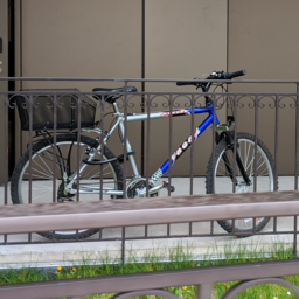

In [21]:
# Use Image.fromarray() method to build a displayable img object
# Print the 6th image from the train dataset
img = Image.fromarray(np.array(data_dict['train']['data'][5]*255, dtype=np.uint8), IMAGE_COLOR_SPACE)
img



To ensure that the resul is correct, here is the display of the 6th picture of the train dataset using the original PNG file (bike is the first loaded subfolder according to the order we've defined in the DATASET_NAME global constant)

bike/bike-0006.png


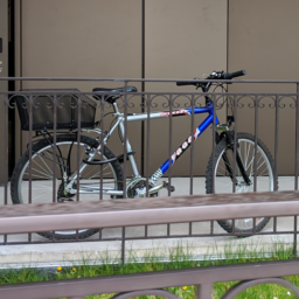

In [24]:
# Use data_dict to get the filename of the image
img=Image.open(os.path.join('data', 'train', data_dict['train']['filenames'][5]))

# Resize it to get a result more inline with the above picture
print(data_dict['train']['filenames'][5])
img.resize((299,299), Image.BICUBIC)

That'all folks for this first Notebook. Let's move on the second one.